# Tensorflow2 KeyNotes
### ==== Neural Network based Multivariate Regression (TF2) ====
### Instructions

These serial notebooks are intended to record my practicing and keynotes with deep learning in the framework of TensorFlow 2. Within these notebooks, I demonstrate the networks with specific examples and my personal interpretations.  You can find instructions in each section for each project.  Feel free to refer to it if is helpful for your work. 

In this notebook, I demonstrate an example of using the least square regression and dense neural network-based regression method to solve the multivariate regression problem. The analytic 2D Frank function is used in this experiment. The following contents are included in this notebook:

1. Data simulation with 2D Frank function
2. Least square regression with up to 5th order of multivariables.
3. Dense neural network-based multivariate regression.
4. Quantitative comparison.

### Code by Hao, Zhao, Oct, 2020.



### Import the tensorflow library

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0



###  Load the external libraries

In [2]:
import numpy as np
import tensorflow as tf
import time

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,Conv1D,SimpleRNN,AveragePooling1D,Flatten
from random import random, seed
from sklearn.model_selection import train_test_split


###  Using 2D Franke function for multivariate regression experiment


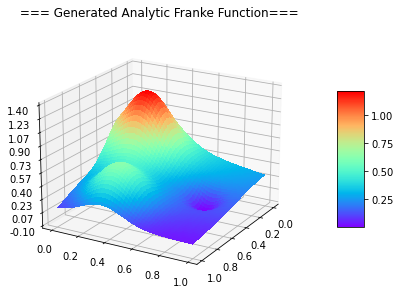

In [3]:
fig = plt.figure(1,figsize=(15,5))
ax = fig.gca(projection='3d')

# Make data.
x = np.arange(0, 1, 0.01)
y = np.arange(0, 1, 0.01)
x, y = np.meshgrid(x,y)


def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.rainbow,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.view_init(20, 30)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title(' === Generated Analytic Franke Function=== ')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

------------------------------------------
##  Method-1: Least-square multivariate regression 
------------------------------------------

To solve the multivariate regression problem by least-square methods, we recall the formulation or the linear regression:

$$
\mathbf{y}=X \boldsymbol{\beta}+\varepsilon
$$

where, $\mathbf{X}$, $\mathbf{y}$ are observations, $\hat{\beta}$ is the model parameters to be derived, and $\varepsilon$ is the random error term added in the observation.    

Based on the concept of least-square error, the model parameter $\hat{\beta}$ can be derived with below matrix notation:

$$
\overrightarrow{\hat{\beta}}=\left(X^{T} X\right)^{-1} X^{T} Y
$$

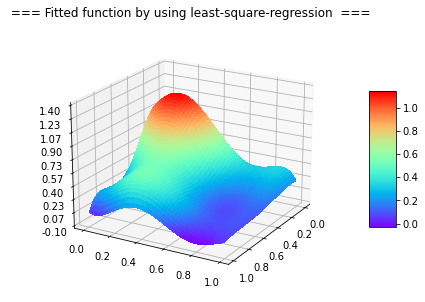

In [4]:
# create 1-d vector for x, y and z
x_vec = x.reshape(x.size,1) 
y_vec = y.reshape(y.size,1)
z_vec = z.reshape(z.size,1)

# generate the design matrix 

def design_matrix_set(x=x_vec,y=y_vec,BaseNumber=21):
    
    # define the design matrix up to 5th order of multivariables x and y (21 bases in total) 
    A_matrix_full = np.c_[np.ones(x.shape), x, y, x**2, y**2, x*y, x**3, y**3, x**2*y, x*y**2, x**4, y**4, x**3*y, x**2*y**2, x*y**3, x**5, y**5, x**4*y, x**3*y**2, x**2*y**3, x*y**4]            

    # select the number of bases for output
    A_matrix = A_matrix_full[:,:BaseNumber]
    
    return A_matrix
        
            
# derive model parameters Beta
array_A = design_matrix_set(x_vec,y_vec,BaseNumber=21)
beta    = np.linalg.inv(array_A.T.dot(array_A)).dot(array_A.T).dot(z_vec)

# generate the predicted z values based on derived model
zpredict = array_A.dot(beta)
zpredict = zpredict.reshape(z.shape)

# plot the derived prediction
fig = plt.figure(2,figsize=(15,5))
ax  = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(x, y, zpredict, cmap=cm.rainbow,linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.view_init(20, 30)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title(' === Fitted function by using least-square-regression  === ')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()    


------------------------------------------
##  Method-2: Dense neural network based multivariate regression 
------------------------------------------

### Data preparation for the Neural Network training and testing

In [5]:
# Generate the training and testing batches for the neural network. 
# Be aware of the 'sequence bias': if the training datasets are not randomly selected, the model accuracy will be adversely affected.
# Thus, in this test, I am using the sciki-learn module for data splitting.  

def dataset_batch_generation(x,y,z,trainset_ratio):
    input  = np.concatenate((x,y),axis=1)
    target = z
    
    # split data into train and test set
    train_input,test_input, train_target,test_target = train_test_split(input, target, train_size=trainset_ratio, random_state=50)
    
    return train_input,train_target,test_input,test_target
    

train_input,train_target,test_input,test_target = dataset_batch_generation(x_vec,y_vec,z_vec,0.9)

### Build a dense neural network

In [6]:

model = Sequential([Dense(64,activation='relu',input_shape=(2,)),
                    Dense(128,activation='relu'),
                    Dense(1)
                    ])

model.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse',metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________


### Train the neural network

In [7]:
start      = time.time()
history    = model.fit(train_input,train_target,batch_size=64,epochs=100,validation_split=0.10,verbose=1)
trian_time = time.time()-start
print("Training completed in : {:0.2f}ms".format(1000*trian_time))

Epoch 1/100
127/127 [==============================] - 0s 2ms/step - loss: 0.0572 - mae: 0.1601 - val_loss: 0.0095 - val_mae: 0.0750
Epoch 2/100
127/127 [==============================] - 0s 1ms/step - loss: 0.0073 - mae: 0.0651 - val_loss: 0.0062 - val_mae: 0.0581
Epoch 3/100
127/127 [==============================] - 0s 1ms/step - loss: 0.0051 - mae: 0.0538 - val_loss: 0.0042 - val_mae: 0.0482
Epoch 4/100
127/127 [==============================] - 0s 1ms/step - loss: 0.0035 - mae: 0.0444 - val_loss: 0.0028 - val_mae: 0.0394
Epoch 5/100
127/127 [==============================] - 0s 1ms/step - loss: 0.0025 - mae: 0.0370 - val_loss: 0.0023 - val_mae: 0.0349
Epoch 6/100
127/127 [==============================] - 0s 1ms/step - loss: 0.0021 - mae: 0.0328 - val_loss: 0.0018 - val_mae: 0.0306
Epoch 7/100
127/127 [==============================] - 0s 1ms/step - loss: 0.0018 - mae: 0.0296 - val_loss: 0.0016 - val_mae: 0.0273
Epoch 8/100
127/127 [==============================] - 0s 1ms/step - 

127/127 [==============================] - 0s 1ms/step - loss: 6.1537e-05 - mae: 0.0060 - val_loss: 1.6642e-04 - val_mae: 0.0114
Epoch 60/100
127/127 [==============================] - 0s 1ms/step - loss: 6.2786e-05 - mae: 0.0060 - val_loss: 5.4575e-05 - val_mae: 0.0056
Epoch 61/100
127/127 [==============================] - 0s 1ms/step - loss: 5.7626e-05 - mae: 0.0058 - val_loss: 4.8392e-05 - val_mae: 0.0053
Epoch 62/100
127/127 [==============================] - 0s 1ms/step - loss: 6.0629e-05 - mae: 0.0060 - val_loss: 4.6972e-05 - val_mae: 0.0050
Epoch 63/100
127/127 [==============================] - 0s 1ms/step - loss: 6.4622e-05 - mae: 0.0062 - val_loss: 4.8651e-05 - val_mae: 0.0052
Epoch 64/100
127/127 [==============================] - 0s 1ms/step - loss: 6.1453e-05 - mae: 0.0060 - val_loss: 1.0113e-04 - val_mae: 0.0086
Epoch 65/100
127/127 [==============================] - 0s 1ms/step - loss: 6.1865e-05 - mae: 0.0060 - val_loss: 5.0473e-05 - val_mae: 0.0055
Epoch 66/100
127/12

### Display of training and validation losses in the network training


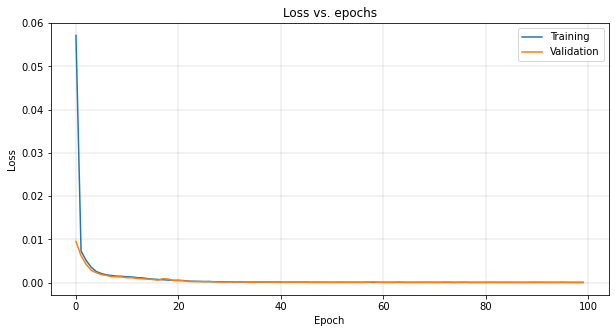

In [8]:
plt.figure(3,figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

### Prediction with test dataset

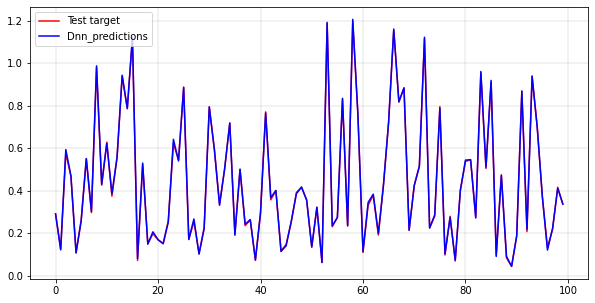

In [9]:
dnn_predictions = model.predict(test_input)

plt.figure(4,figsize=(10, 5))
plt.plot(test_target[:100],'r',label='Test target')
plt.plot(dnn_predictions[:100],'b',label='Dnn_predictions')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(loc='upper left')


----------------------------------------------------------------------
## Comparison of two methods
----------------------------------------------------------------------


### Compare the loss in the finner grid

In [10]:

x_qc = np.arange(0, 1, 0.001)
y_qc = np.arange(0, 1, 0.001)
x_qc, y_qc = np.meshgrid(x_qc,y_qc)
z_qc       = FrankeFunction(x_qc, y_qc) 

# generate the predicted z values bsed on derived regression model
array_A_qc  = design_matrix_set(x_qc.reshape(x_qc.size,1),y_qc.reshape(y_qc.size,1),BaseNumber=21)
zpredict_qc = array_A_qc.dot(beta)
zpredict_qc = zpredict_qc.reshape(z_qc.shape)

# generate the predicted z values based on derived neural network model
zpredictNN_qc = model.predict(np.concatenate((x_qc.reshape(x_qc.size,1),y_qc.reshape(y_qc.size,1)),axis=1))
zpredictNN_qc = zpredictNN_qc.reshape(z_qc.shape)


### Compare the selected 2D section

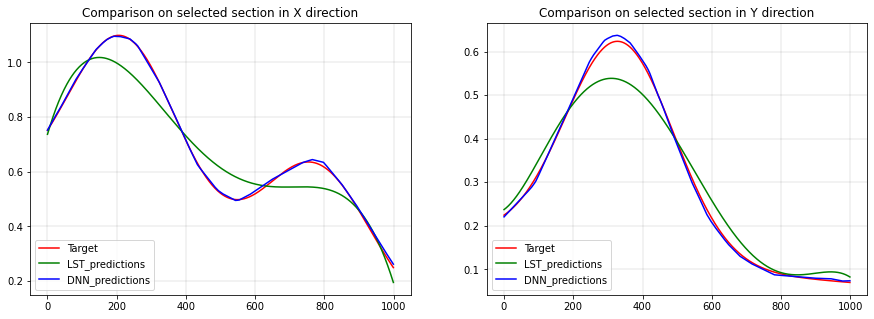

In [11]:
section_x = 300
section_y = 800


plt.figure(5,figsize=(15, 5))
ax = plt.subplot(1,2,1)
ax.plot(z_qc[section_x,:],'r',label='Target')
ax.plot(zpredict_qc[section_x,:],'g',label='LST_predictions')
ax.plot(zpredictNN_qc[section_x,:],'b',label='DNN_predictions')
ax.set_title('Comparison on selected section in X direction')
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.legend(loc='lower left')

ax = plt.subplot(1,2,2)
ax.plot(z_qc[:,section_y],'r',label='Target')
ax.plot(zpredict_qc[:,section_y],'g',label='LST_predictions')
ax.plot(zpredictNN_qc[:,section_y],'b',label='DNN_predictions')
ax.set_title('Comparison on selected section in Y direction')
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.legend(loc='lower left')


### Compare the 3D results

Text(0.5, 0.92, 'Fitted model derived by dense neural network')

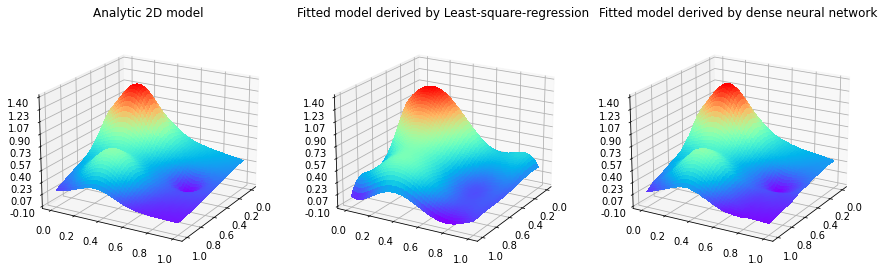

In [12]:
fig = plt.figure(5,figsize=(15, 5))

ax = fig.add_subplot(1,3,1,projection='3d')
surf = ax.plot_surface(x_qc, y_qc, z_qc, cmap=cm.rainbow,linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40)
ax.view_init(20, 30)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title('Analytic 2D model')

ax = fig.add_subplot(1,3,2,projection='3d')
surf = ax.plot_surface(x_qc, y_qc, zpredict_qc, cmap=cm.rainbow,linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40)
ax.view_init(20, 30)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title('Fitted model derived by Least-square-regression')

ax = fig.add_subplot(1,3,3,projection='3d')
surf = ax.plot_surface(x_qc, y_qc, zpredictNN_qc, cmap=cm.rainbow,linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40)
ax.view_init(20, 30)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title('Fitted model derived by dense neural network')



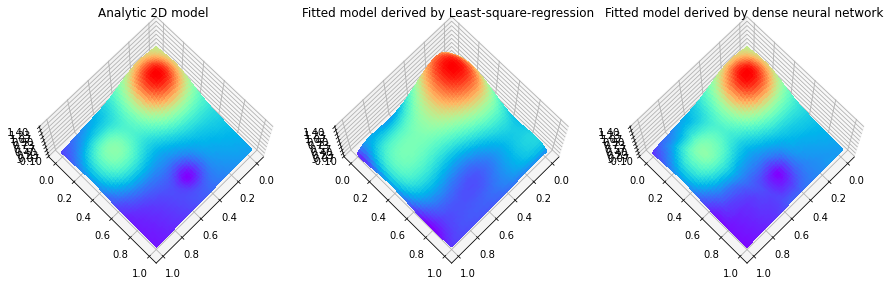

In [13]:
# plot the 3D results (projection view angle)
fig = plt.figure(6,figsize=(15,5))

ax = fig.add_subplot(1,3,1,projection='3d')
surf = ax.plot_surface(x_qc, y_qc, z_qc, cmap=cm.rainbow,linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40)
ax.view_init(75,45)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title('Analytic 2D model')


ax = fig.add_subplot(1,3,2,projection='3d')
surf = ax.plot_surface(x_qc, y_qc, zpredict_qc, cmap=cm.rainbow,linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40)
ax.view_init(75,45)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title('Fitted model derived by Least-square-regression')


ax = fig.add_subplot(1,3,3,projection='3d')
surf = ax.plot_surface(x_qc, y_qc, zpredictNN_qc, cmap=cm.rainbow,linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40)
ax.view_init(75,45)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_title('Fitted model derived by dense neural network')

plt.show()

### Mean square error comparison

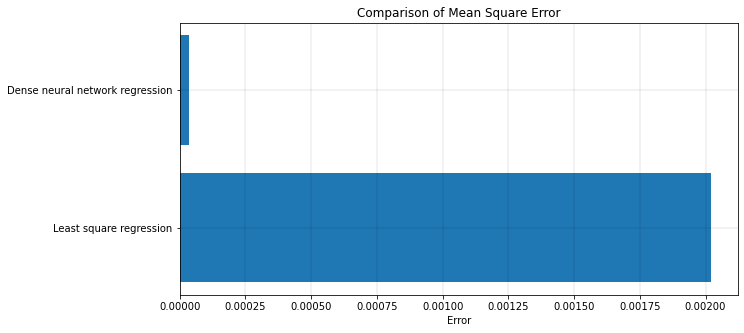

In [14]:
MSE_LSR = tf.keras.losses.mean_squared_error(z_qc.flatten(),zpredict_qc.flatten()).numpy()
MSE_DNN = tf.keras.losses.mean_squared_error(z_qc.flatten(),zpredictNN_qc.flatten()).numpy()


names = ['Least square regression', 'Dense neural network regression']
MSEs  = [MSE_LSR,MSE_DNN]

fig, ax = plt.subplots(figsize=(10,5))
ax.barh(names, MSEs)
ax.set_title('Comparison of Mean Square Error')
ax.set_xlabel('Error')
plt.grid(color='k', linestyle='-', linewidth=0.1)


## Summary

In the above numerical experiments, we demonstrated that solving a multivariate regression problem by a least-square parameter estimation method and a dense neural network approach. The quantitative comparison based on the derived model shows that with sufficient training samples, randomized training set preparation, and proper network architecture, the dense neural network could estimate a reasonable multivariate model and achieve considerably accuracy compared to the least-square based multivariate regression.

## References

Linear regression, https://en.wikipedia.org/wiki/Linear_regression

Trevor Hastie, Robert Tibshirani and Jerome Friedman, The Elements of Statistical Learning- Data Mining, Inference, and Prediction, Springer 2008.